# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [4]:
print(torch.__version__)

0.4.0


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [8]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_set = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
val_set = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_set = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [9]:

    
def show5(img_loader):
    dataiter = iter(img_loader)
    images, labels = dataiter.next()
    images = images.numpy()# convert images to numpy for display
    

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 5 images
    for idx in np.arange(5):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        
        images[idx] = images[idx] / 2 + 0.5  # unnormalize
        plt.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(classes[labels[idx]])

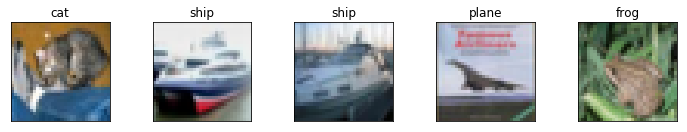

In [10]:
show5(test_set)

In [31]:
# Explore data
# Check the sizes of the datasets
print('Number of images in the training set:', len(train_data))

print('Number of images in the test set:', len(test_data))
print('Total number of images in the CIFAR-10 dataset:', len(train_data)+len(test_data))

Number of images in the training set: 50000
Number of images in the test set: 10000
Total number of images in the CIFAR-10 dataset: 60000


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [23]:
from torch import nn
import torch.nn.functional as F
class classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layer
        self.conv1=nn.Conv2d(3,6,3,padding=1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2=nn.Conv2d(6,12,3,padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3=nn.Conv2d(12,36,3,padding=1)
        self.bn3 = nn.BatchNorm2d(36)
        self.conv4=nn.Conv2d(36,64,3,padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        #linear layer 
        self.fc1 = nn.Linear(16384,1024)
        self.fc2 = nn.Linear(1024,256)
        self.fc3 = nn.Linear(256,64)
        self.fc4 = nn.Linear(64, 10)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.dropout(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(x)
        # flatten image input
        x = x.view(x.shape[0], -1)
    #print(x.shape)
        # add dropout layer
        
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer, with relu activation function
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer, with  LOG_SOFTMAX activation function
        x = F.log_softmax(self.fc4(x),dim=1)
        # add dropout layer
        
        return x
        
            
            
model = classifier()
print(model)            
    



classifier(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(36, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [24]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [25]:
# Use the GPU of the machine if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running on', device)
model.to(device)

Running on cuda


classifier(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(12, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(36, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=

In [27]:

epoch=30
train_losses = []
val_losses = []
val_accuracies =[]

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_set:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        val_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in val_set:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                val_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_set))
        val_losses.append(val_loss/len(val_set))
        val_accuracies.append(accuracy/len(val_set))

        print('Epoch: {}/{}.. '.format(epoch+1, epochs),
              'Training Loss: {:.3f}.. '.format(running_loss/len(train_set)),
              'Validation Loss: {:.3f}.. '.format(val_loss/len(val_set)),
              'Validation Accuracy: {:.3f}'.format(accuracy/len(val_set)))

Epoch: 1/30..  Training Loss: 1.359..  Validation Loss: 1.169..  Validation Accuracy: 0.601
Epoch: 2/30..  Training Loss: 1.194..  Validation Loss: 1.089..  Validation Accuracy: 0.623
Epoch: 3/30..  Training Loss: 1.070..  Validation Loss: 0.995..  Validation Accuracy: 0.663
Epoch: 4/30..  Training Loss: 0.979..  Validation Loss: 0.932..  Validation Accuracy: 0.678
Epoch: 5/30..  Training Loss: 0.883..  Validation Loss: 0.943..  Validation Accuracy: 0.671
Epoch: 6/30..  Training Loss: 0.814..  Validation Loss: 0.881..  Validation Accuracy: 0.698
Epoch: 7/30..  Training Loss: 0.742..  Validation Loss: 0.899..  Validation Accuracy: 0.698
Epoch: 8/30..  Training Loss: 0.685..  Validation Loss: 0.872..  Validation Accuracy: 0.705
Epoch: 9/30..  Training Loss: 0.624..  Validation Loss: 0.902..  Validation Accuracy: 0.709
Epoch: 10/30..  Training Loss: 0.583..  Validation Loss: 0.917..  Validation Accuracy: 0.705
Epoch: 11/30..  Training Loss: 0.533..  Validation Loss: 0.924..  Validation Ac

Plot the training loss (and validation loss/accuracy, if recorded).

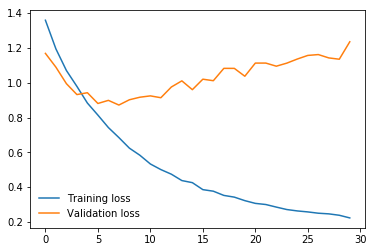

In [32]:
## YOUR CODE HERE ##
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

##### As can be seen from the graph above, we have to stop the training at 7th epoch


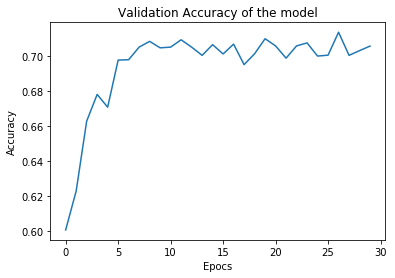

In [33]:
plt.plot(val_accuracies)
plt.xlabel('Epocs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy of the model')
plt.legend(frameon=False)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [35]:
test_accuracy = 0
        
with torch.no_grad():
    
    model.eval()
    for images, labels in test_set:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor))
print('Test Accuracy: {:.1f}%'.format(test_accuracy/len(test_set)*100))

Test Accuracy: 70.3%


## Saving your model
Using `torch.save`, save your model for future loading.

In [36]:
model_checkpoint={'stat_dict':model.state_dict(),
                 'optim_dict':optimizer.state_dict()}

torch.save(model_checkpoint,'CIFAR10_model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

As shown from the above result, we can easily obtain accuracy of 70% with a simple architecture. Moreover, there is more room for enhancing the model to achieve a higher accuracy rate. Nevertheless, our model's accuracy is lower than the advanced model such as GPipe, but from a computation perspective, our model is more efficient thanks to its simple architecture. Since our company is looking for %70 accuracy, we can enhance and deploy our model rather than buying Detectocorp’s algorithm.


## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).